In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('data/citibike_ZIP.csv')
df.head()

,tripduration,starttime,stoptime,start_id,start_name,start_lat,start_lon,end_id,end_name,end_lat,end_lon,bikeid,usertype,birth_year,gender,weekday,hour,geometry,zip_start,zip_end
0,17.700000,2020-06-01 00:00:03.372,2020-06-01 00:17:46.208,3419,Douglass St & 4 Ave,40.679279,-73.981540,3419,Douglass St & 4 Ave,40.679279,-73.981540,39852,Customer,1997,2,0,0,POINT (989370.1838770027 186756.53892500512),11217,11217.0
1,63.500000,2020-06-01 00:00:03.553,2020-06-01 01:03:33.936,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,336,Sullivan St & Washington Sq,40.730477,-73.999061,37558,Subscriber,1969,0,0,0,POINT (992875.4144866021 191851.65323921342),11205,10012.0
2,16.950000,2020-06-01 00:00:09.614,2020-06-01 00:17:06.833,389,Broadway & Berry St,40.710446,-73.965251,3562,Classon Ave & St Marks Ave,40.676520,-73.959608,37512,Customer,1988,2,0,0,POINT (993883.8241576733 198112.87322040228),11249,11238.0
3,3.766667,2020-06-01 00:00:12.178,2020-06-01 00:03:58.864,3255,8 Ave & W 31 St,40.750585,-73.994685,505,6 Ave & W 33 St,40.749013,-73.988484,39674,Customer,1969,0,0,0,POINT (985722.6805079061 212735.19209770544),10001,10001.0
4,23.950000,2020-06-01 00:00:21.255,2020-06-01 00:24:18.965,367,E 53 St & Lexington Ave,40.758281,-73.970694,497,E 17 St & Broadway,40.737050,-73.990093,21093,Customer,1997,2,0,0,POINT (992368.8021711168 215540.1540624901),10022,10003.0


In [45]:
start_count = df.groupby(['zip_start'], as_index=False)['bikeid'].count()
start_count.columns = ['zip_start','start_count']
start_count.head()

,zip_start,start_count
0,83,70803
1,10001,63816
2,10002,78029
3,10003,92930
4,10004,10921


In [46]:
end_count = df.groupby(['zip_end'], as_index=False)['bikeid'].count()
end_count.columns = ['zip_end','end_count']
end_count.head()

,zip_end,end_count
0,83.0,69557
1,10001.0,63180
2,10002.0,78867
3,10003.0,93889
4,10004.0,11250


In [47]:
zip_count = start_count.merge(end_count,
                             left_on = 'zip_start',
                             right_on = 'zip_end',
                             how = 'left')
zip_count.head()

,zip_start,start_count,zip_end,end_count
0,83,70803,83.0,69557
1,10001,63816,10001.0,63180
2,10002,78029,10002.0,78867
3,10003,92930,10003.0,93889
4,10004,10921,10004.0,11250


In [49]:
# import zip code file
zip_shp = gpd.read_file('nyc_zip/ZIP_CODE_040114.shp')[['ZIPCODE', 'geometry']]
zip_shp['ZIPCODE'] = zip_shp['ZIPCODE'].astype(int)
zip_shp.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [50]:
zip_shp = zip_shp.merge(
    zip_count, 
    left_on='ZIPCODE',
    right_on='zip_start',
    how='left')
zip_shp.head()

,ZIPCODE,geometry,zip_start,start_count,zip_end,end_count
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",NaN,NaN,NaN,NaN
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",NaN,NaN,NaN,NaN
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",NaN,NaN,NaN,NaN
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18...",11225.0,9237.0,11225.0,9316.0
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17...",NaN,NaN,NaN,NaN


In [51]:
zip_shp['start_count'].fillna(0, inplace=True)
zip_shp['end_count'].fillna(0, inplace=True)

In [52]:
# define total surplus as difference between end count and start count in each zipcode

zip_shp['surplus_tot'] = zip_shp['end_count'] - zip_shp['start_count']
zip_shp['surplus_daily'] = zip_shp['surplus_tot']/30
zip_shp['surplus_daily'].describe()

count    263.000000
mean       0.175792
std       10.200333
min      -67.100000
25%        0.000000
50%        0.000000
75%        0.000000
max       73.833333
Name: surplus_daily, dtype: float64

[]

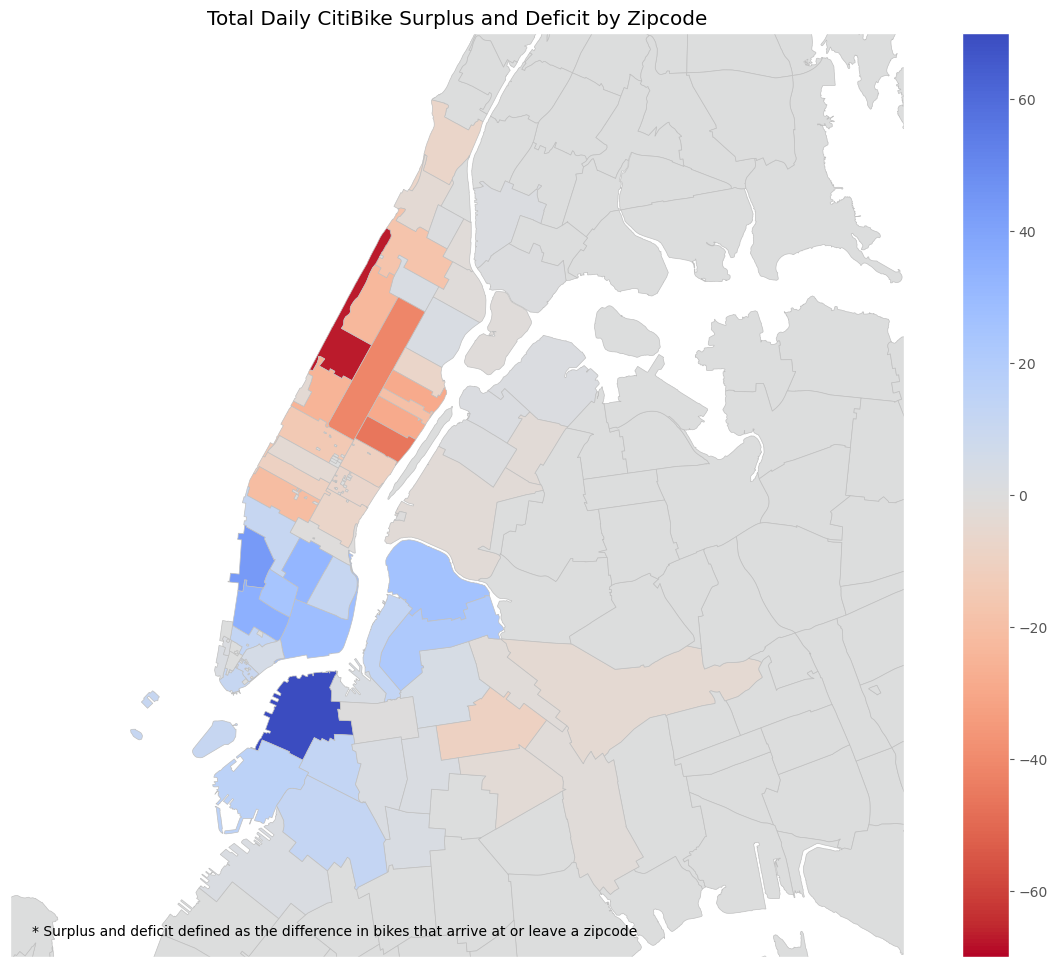

In [59]:
from matplotlib.colors import Normalize
norm = Normalize(vmin=-70, vmax=70)

fig, ax = plt.subplots(figsize = (15,12))

zip_shp.plot(ax=ax, column= 'surplus_daily', cmap='coolwarm_r', norm=norm, edgecolor = 'silver', legend=True)

plt.title('Total Daily CitiBike Surplus and Deficit by Zipcode')
plt.text(962000, 172056, '* Surplus and deficit defined as the difference in bikes that arrive at or leave a zipcode')

ax.set_xlim(960000, 1042546)
ax.set_ylim(170056, 255352)
ax.set_facecolor("white")
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])